In [221]:
import numpy as np
import pandas as pd
import scipy.linalg

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

import sys
print(sys.version)
sys.path.append('../')

from models.powertrain.bounded_powertrain import Bounded_powertrain
from models.kinematic.ideal_diff_drive import Ideal_diff_drive
from models.kinematic.ICR_based import *
from models.kinematic.Perturbed_unicycle import *
from models.kinematic.enhanced_kinematic import *


3.10.9 (main, Jan 11 2023, 09:18:20) [Clang 14.0.6 ]


In [222]:
# === import training dataset ========================================================================

# dataset_snow = pd.read_pickle('/home/dominic/repos/norlab_WMRD/data/marmotte/ga_hard_snow_25_01_a/slip_dataset_all.pkl')
dataset_snow: pd.DataFrame = pd.read_pickle('/Users/redleader/PycharmProjects/norlab_WMRD/data/marmotte/ga_hard_snow_25_01_a/slip_dataset_all.pkl')

print(dataset_snow.head())

   init_icp_x  init_icp_y  init_icp_z  init_icp_roll  init_icp_pitch  \
0         0.0         0.0         0.0            0.0             0.0   
1         0.0         0.0         0.0            0.0             0.0   
2         0.0         0.0         0.0            0.0             0.0   
3         0.0         0.0         0.0            0.0             0.0   
4         0.0         0.0         0.0            0.0             0.0   

   init_icp_yaw  calib_step  cmd_left_0  cmd_right_0  cmd_left_1  ...  \
0           0.0         0.0    0.000000     0.000000    6.337527  ...   
1           0.0         0.0    6.337527     6.558533    6.337527  ...   
2           0.0         0.0    6.337527     6.558533    6.337527  ...   
3           0.0         1.0   -5.933710     5.305197   -5.933710  ...   
4           0.0         1.0   -5.933710     5.305197   -5.933710  ...   

   body_vel_disturption_yaw_30  body_vel_disturption_yaw_31  \
0                     0.001605                     0.006716   
1 

In [223]:
# [*dataset_snow.keys()]

In [224]:
# === extract body_vel_distruptions arrays (output arrays) ===========================================

str_body_vel_disturption_x_list = []
str_body_vel_disturption_y_list = []
str_body_vel_disturption_yaw_list = []
for i in range(0, 40):
    str_body_vel_disturption_x_i = 'body_vel_disturption_x_' + str(i)
    str_body_vel_disturption_y_i = 'body_vel_disturption_y_' + str(i)
    str_body_vel_disturption_yaw_i = 'body_vel_disturption_yaw_' + str(i)
    str_body_vel_disturption_x_list.append(str_body_vel_disturption_x_i)
    str_body_vel_disturption_y_list.append(str_body_vel_disturption_y_i)
    str_body_vel_disturption_yaw_list.append(str_body_vel_disturption_yaw_i)
    
body_vel_disturption_x_array = dataset_snow[str_body_vel_disturption_x_list].to_numpy()
body_vel_disturption_y_array = dataset_snow[str_body_vel_disturption_y_list].to_numpy()
body_vel_disturption_yaw_array = dataset_snow[str_body_vel_disturption_yaw_list].to_numpy()

y_train_longitudinal_slip = body_vel_disturption_x_array.flatten()
y_train_lateral_slip = body_vel_disturption_y_array.flatten()
y_train_angular_slip = body_vel_disturption_yaw_array.flatten()

print(np.max(y_train_angular_slip))

2.8881285042196287


In [225]:
# === extract interpolated_icp =======================================================================

str_icp_interpolated_x_list = []
str_icp_interpolated_y_list = []
str_icp_interpolated_yaw_list = []
for i in range(0, 40):
    str_icp_interpolated_x_i = 'icp_interpolated_x_' + str(i)
    str_icp_interpolated_y_i = 'icp_interpolated_y_' + str(i)
    str_icp_interpolated_yaw_i = 'icp_interpolated_yaw_' + str(i)
    str_icp_interpolated_x_list.append(str_icp_interpolated_x_i)
    str_icp_interpolated_y_list.append(str_icp_interpolated_y_i)
    str_icp_interpolated_yaw_list.append(str_icp_interpolated_yaw_i)
    
icp_interpolated_x_array = dataset_snow[str_icp_interpolated_x_list].to_numpy()
icp_interpolated_y_array = dataset_snow[str_icp_interpolated_y_list].to_numpy()
icp_interpolated_yaw_array = dataset_snow[str_icp_interpolated_yaw_list].to_numpy()

In [226]:
# === extract icp vels ===============================================================================

str_icp_vel_x_list = []
str_icp_vel_y_list = []
str_icp_vel_yaw_list = []
for i in range(0, 40):
    str_icp_vel_x_i = 'icp_vel_x_' + str(i)
    str_icp_vel_y_i = 'icp_vel_y_' + str(i)
    str_icp_vel_yaw_i = 'icp_vel_yaw_' + str(i)
    str_icp_vel_x_list.append(str_icp_vel_x_i)
    str_icp_vel_y_list.append(str_icp_vel_y_i)
    str_icp_vel_yaw_list.append(str_icp_vel_yaw_i)
    
icp_vel_x_array = dataset_snow[str_icp_vel_x_list].to_numpy()
icp_vel_y_array = dataset_snow[str_icp_vel_y_list].to_numpy()
icp_vel_yaw_array = dataset_snow[str_icp_vel_yaw_list].to_numpy()

In [227]:
# === extract idd_body_vel arrays (input arrays) =====================================================

idd_body_vel_x_str_list = []
idd_body_vel_y_str_list = []
idd_body_vel_yaw_str_list = []
for i in range(0, 40):
    str_idd_vel_x_i = 'idd_vel_x_' + str(i)
    str_idd_vel_y_i = 'idd_vel_y_' + str(i)
    str_idd_vel_yaw_i = 'idd_vel_yaw_' + str(i)
    idd_body_vel_x_str_list.append(str_idd_vel_x_i)
    idd_body_vel_y_str_list.append(str_idd_vel_y_i)
    idd_body_vel_yaw_str_list.append(str_idd_vel_yaw_i)
idd_body_vel_x_array = dataset_snow[idd_body_vel_x_str_list].to_numpy()
idd_body_vel_y_array = dataset_snow[idd_body_vel_y_str_list].to_numpy()
idd_body_vel_yaw_array = dataset_snow[idd_body_vel_yaw_str_list].to_numpy()

# x_train = np.column_stack((idd_body_vel_x_array.flatten(), idd_body_vel_yaw_array.flatten()))

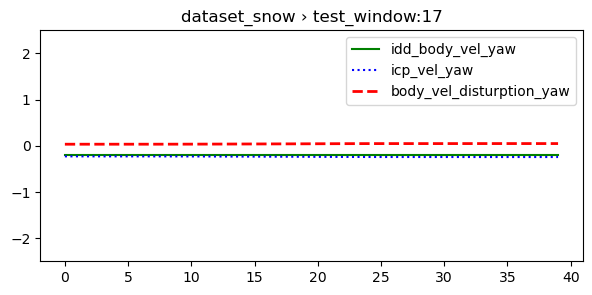

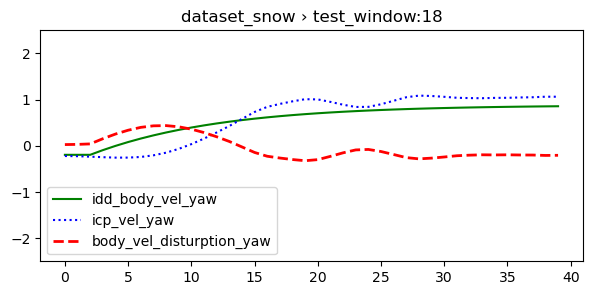

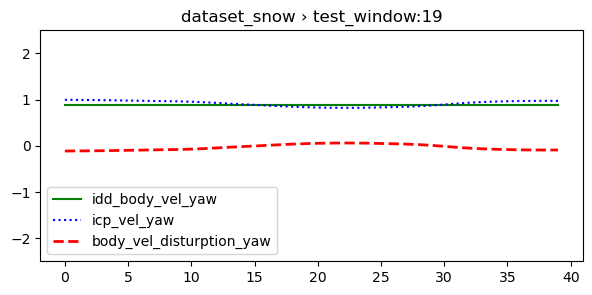

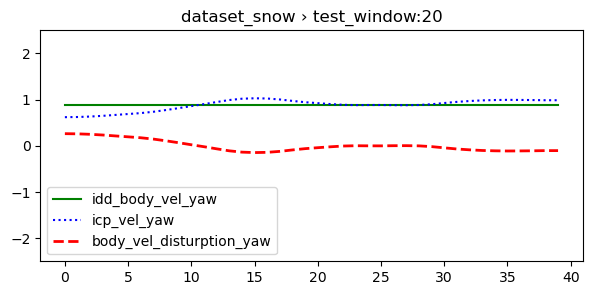

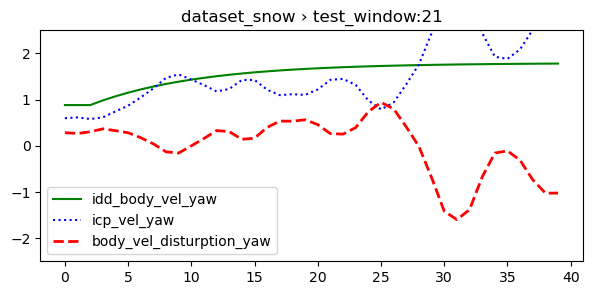

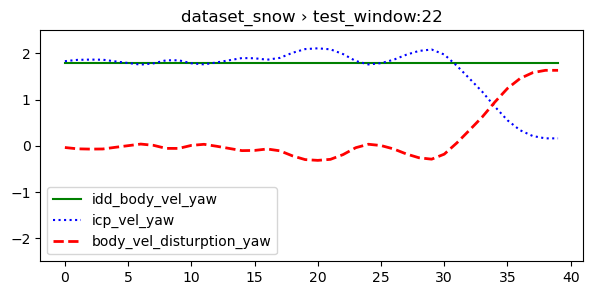

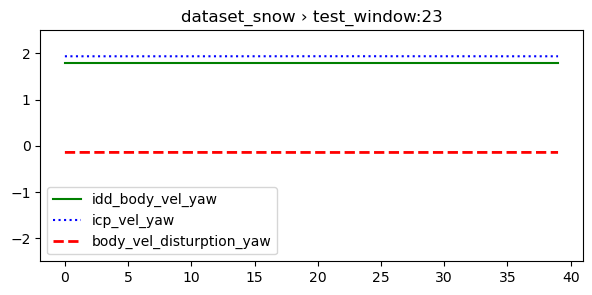

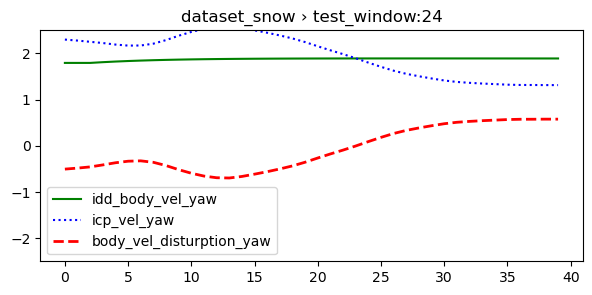

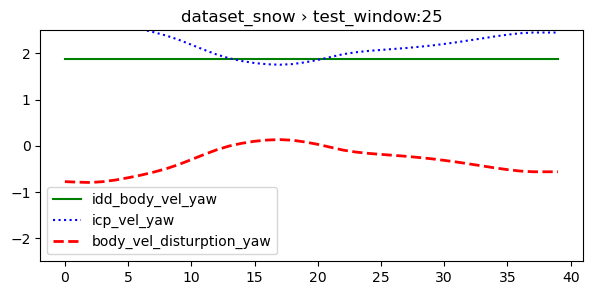

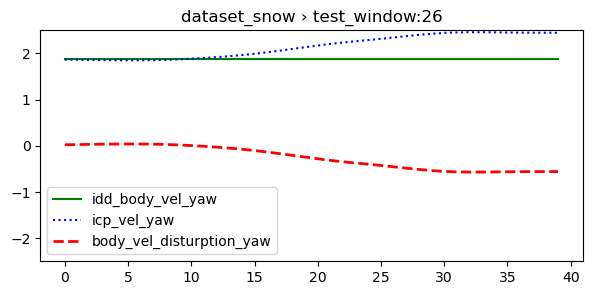

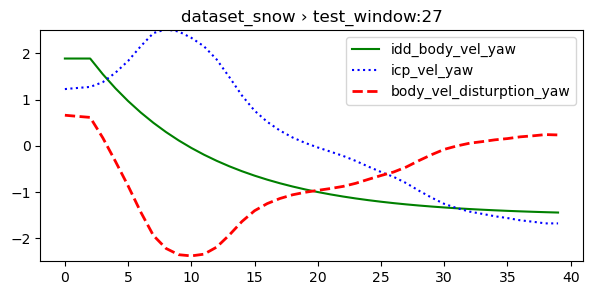

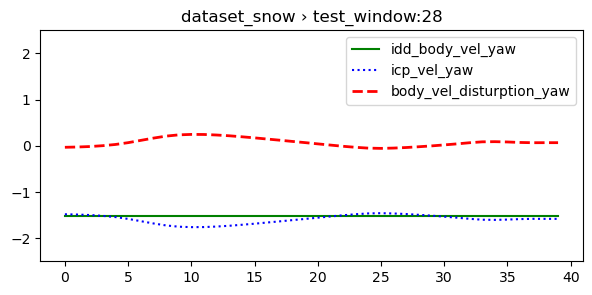

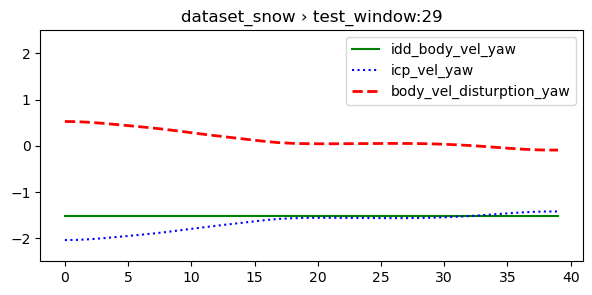

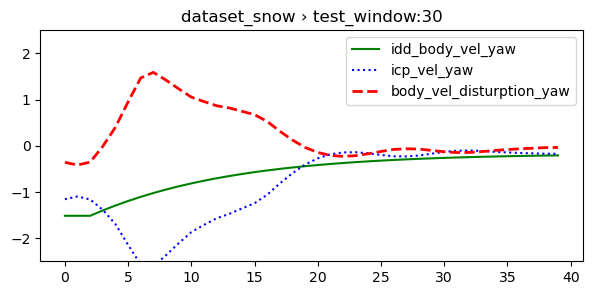

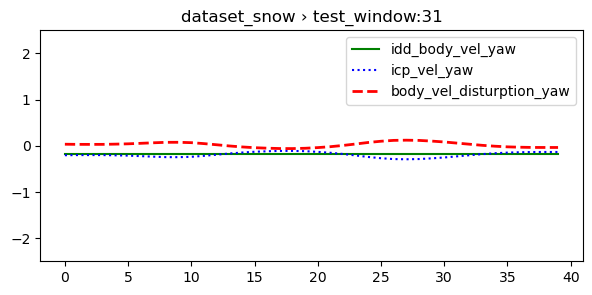

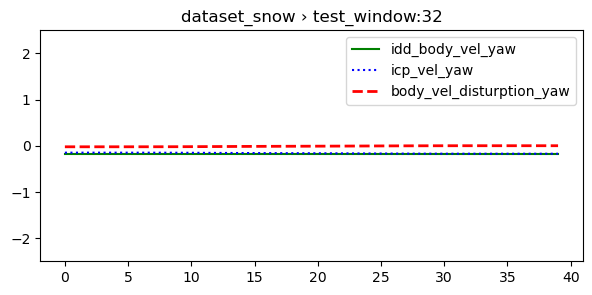

In [228]:
test_window = 32

def plot_dataset_trajectory(trajectory_id):
    fig = plt.figure(num=trajectory_id, figsize=(7,3), dpi=None, facecolor=None, edgecolor=None)
    plt.title(f'dataset_snow › test_window:{trajectory_id}')
    plt.plot(idd_body_vel_yaw_array[trajectory_id, :], label="idd_body_vel_yaw", color="green")
    plt.plot(icp_vel_yaw_array[trajectory_id, :], label="icp_vel_yaw", color="blue", linestyle="dotted")
    # plt.plot(icp_interpolated_yaw_array[trajectory_nb, :], label="icp_interpolated_yaw", color="lightgray", linestyle="dotted")
    plt.plot(body_vel_disturption_yaw_array[trajectory_id, :], label="body_vel_disturption_yaw", color="red", linestyle="dashed", linewidth="2.")
    plt.legend()
    plt.ylim(-2.5, 2.5)
    return None

# print(dataset_snow.loc[test_window]['icp_vel_x_1'])
# print(dataset_snow.loc[test_window]['icp_vel_x_2'])
# print(icp_interpolated_yaw_array[test_window])

for _trj_id in range(17,33): # [29,30,31,32]
    plot_dataset_trajectory(_trj_id)


In [229]:
# === Split train/test dataset =======================================================================

trajectory_length = body_vel_disturption_yaw_array.shape[1]
trajectory_size = body_vel_disturption_yaw_array.shape[0]
dimension = 1
x = np.linspace(start=0, stop=trajectory_length, num=trajectory_size)
X_train = x.reshape(trajectory_size,dimension)

y_train = body_vel_disturption_yaw_array[0:309,:]

In [230]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.15, shuffle=False, random_state=0)
# X_train
# X_test
# y_train
# y_test

In [231]:
# === Create gaussian process ========================================================================
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

kernel = RBF()
gpr = GaussianProcessRegressor(kernel=kernel, )
# gpr.fit(x_train, y_train_angular_slip)
gpr.fit(X_train, y_train)

gpr.score(X_train, y_train)

# gpr.predict(X[:2,:], return_std=True)


/Users/redleader/.conda/envs/norlab_WMRD/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


1.0

In [232]:
gpr.score(X_test, y_test)


-0.049665484972644926